## Color Histograms
#### Traditionally, many technologies relied on manually appending metadata to images and searching via this metadata. This approach works for datasets with high-quality annotation, but most datasets are too large for manual annotation.

#### That means any large image dataset must rely on Content-Based Image Retrieval (CBIR). Search with CBIR focuses on comparing the content of an image rather than its metadata. Content can be color, shapes, textures – or with some of the latest advances in ML - the "human meaning" behind an image.

#### Color histograms represent one of the first CBIR techniques, allowing us to search through images based on their color profiles rather than metadata.
#### - When we build and search with our color histograms we are going to convert them into a single image embedding vector. 

#### Core idea of color histograms: Take an image, translate it into color-based histograms, and use these histograms to retrieve images with similar color profiles.

In [5]:
from datasets import load_dataset

data = load_dataset('pinecone/image-set', split='train', revision='e7d39fc') # small 21 image dataset
data

Dataset({
    features: ['image_bytes', 'image'],
    num_rows: 21
})

#### - image_bytes is a base64 encoded representation of our image bytes. When the images are downloaded they need to be decoded. 

In [25]:
from base64 import b64decode
import cv2
import numpy as np

def process_fn(sample):
    image_bytes = b64decode(sample['image_bytes'])
    image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)
    return image

images = [process_fn(sample) for sample in data]

#### - OpenCV loads images in a (BGR) format. Matplotlib expected RGB, so we must flip the color channels of the array to get the true color image.

In [ ]:
shape = images[0].shape
shape, images[0][0, 0, :]

import numpy as np

rgb_image = np.flip(images[0], 2)

shape = rgb_image.shape         # Height, Width, color channels 
shape, rgb_image[0, 0, :]       # channel values 


((1600, 2560, 3), array([134, 174, 165], dtype=uint8))

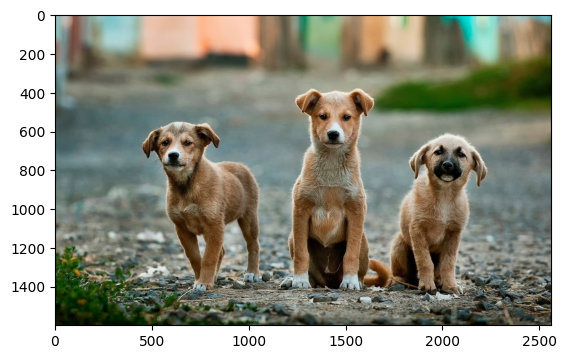

In [13]:
import matplotlib.pyplot as plt

plt.imshow(rgb_image)

#### - The color channel values for all pixels in the image are presently stored in an array of equal dimensions to the original image. When comparing image embeddings the most efficient techniques rely on comparing vectors not arrays. To handle this, we reshape the rows and columns of the image array into a single row (vector).

In [ ]:
image_vector = rgb_image.reshape(1, -1, 3)
image_vector.shape      # All of the rows concatenated together 

(1, 4096000, 3)

#### - Still technically an array because of the three color channels. Need to extract those out to make three vectors for each color. 

In [16]:
red = image_vector[0, :, 0]
green = image_vector[0, :, 1]
blue = image_vector[0, :, 2]

red.shape, green.shape, blue.shape

((4096000,), (4096000,), (4096000,))

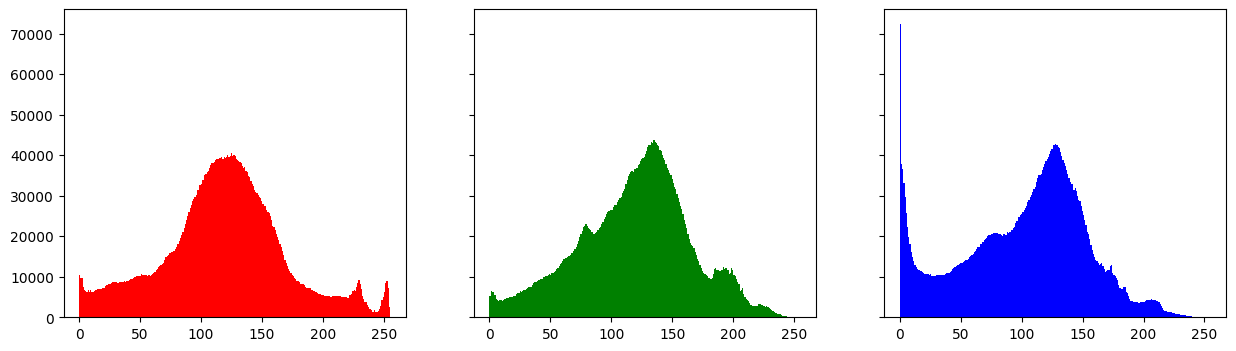

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axs[0].hist(red, bins=256, color='r')
axs[1].hist(green, bins=256, color='g')
axs[2].hist(blue, bins=256, color='b')
plt.show()  # Displays the RGB color profile

In [20]:
def build_histogram(image, bins=256):       # Lowering the bins value does not generally effect the retreival performace unless significantly decreased. 
    # convert from BGR to RGB
    rgb_image = np.flip(image, 2)
    # show the image
    plt.imshow(rgb_image)
    # convert to a vector
    image_vector = rgb_image.reshape(1, -1, 3)
    # break into given number of bins
    div = 256 / bins
    bins_vector = (image_vector / div).astype(int)      # Quick bin creation 
    # get the red, green, and blue channels
    red = bins_vector[0, :, 0]
    green = bins_vector[0, :, 1]
    blue = bins_vector[0, :, 2]
    # build the histograms and display
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    axs[0].hist(red, bins=bins, color='r')
    axs[1].hist(green, bins=bins, color='g')
    axs[2].hist(blue, bins=bins, color='b')
    plt.show()

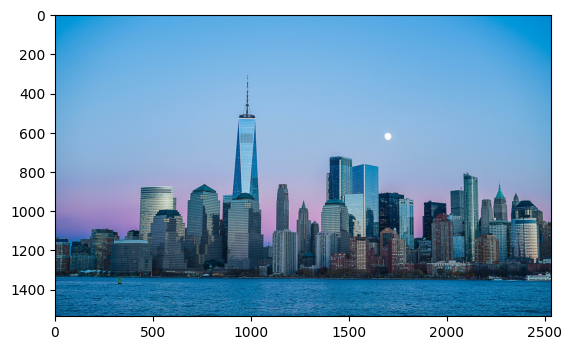

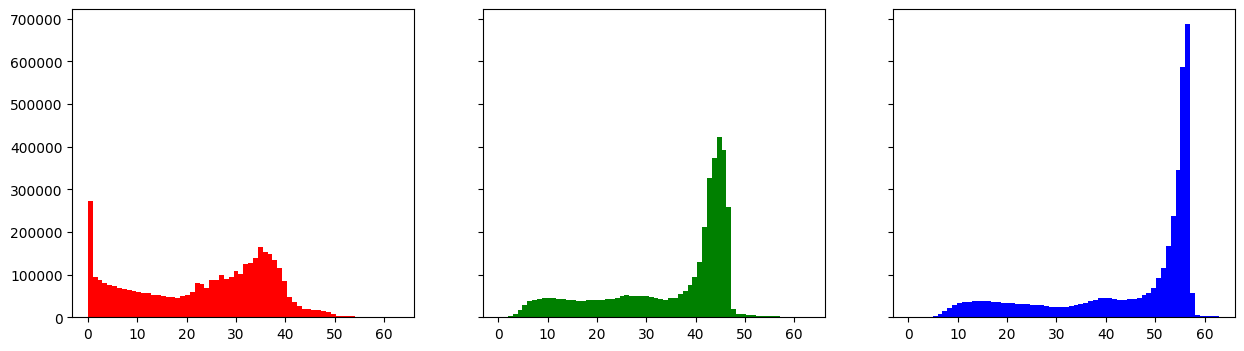

In [23]:
build_histogram(images[1], 64)

#### Building histograms can be abstracted to be done more easily using the OpenCV library. OpenCV has a function called calcHist specifically for building histograms

In [ ]:
red_hist = cv2.calcHist([images[5]], [2], None, [64], [0, 256])     # (images, channels, mask, histSize, ranges[, hist[, accumulate]])
green_hist = cv2.calcHist([images[5]], [1], None, [64], [0, 256])   # Mask is just an array of 0s and 1s 
blue_hist = cv2.calcHist([images[5]], [0], None, [64], [0, 256])    # Top value of the range is not included. 

red_hist.shape


(64, 1)

In [31]:
help(cv2.calcHist)

Help on built-in function calcHist:

calcHist(...)
    calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]]) -> hist
    .   @overload
    .   
    .   this variant supports only uniform histograms.
    .   
    .   ranges argument is either empty vector or a flattened vector of histSize.size()*2 elements
    .   (histSize.size() element pairs). The first and second elements of each pair specify the lower and
    .   upper boundaries.



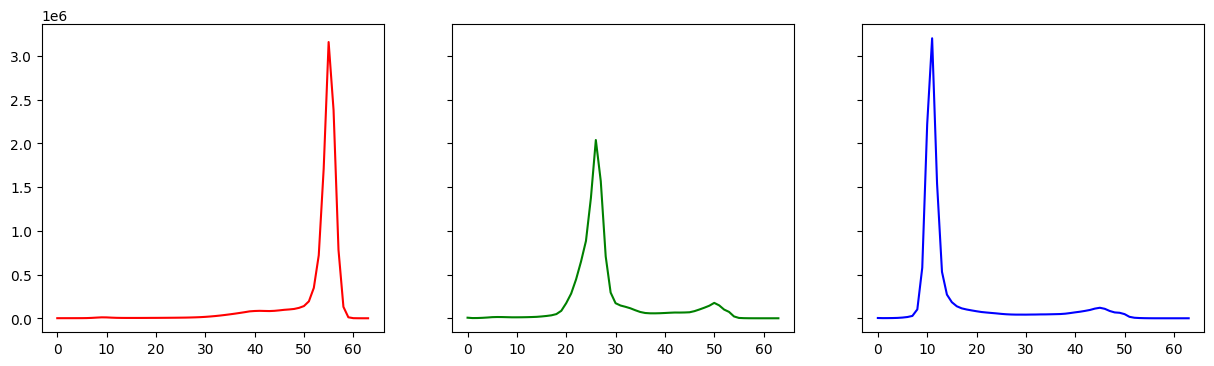

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axs[0].plot(red_hist, color='r')
axs[1].plot(green_hist, color='g')
axs[2].plot(blue_hist, color='b')
plt.show()

### Creating embeddings for color histograms
### Vectors and similarities 
#### Have a function for transforming our images into three vectors representing the three color channels. Before comparing our images we must concatenate these three vectors into a single vector.
#### packed into: get_vector
#### we can then compare using Euclidean distance or cosine similarity 

In [33]:
def get_vector(image, bins=32):
    red = cv2.calcHist([image], [2], None, [bins], [0, 256])
    green = cv2.calcHist([image], [1], None, [bins], [0, 256])
    blue = cv2.calcHist([image], [0], None, [bins], [0, 256])
    vector = np.concatenate([red, green, blue], axis=0)
    vector = vector.reshape(-1)         # remove the extra dimension 
    return vector

In [38]:
vec = get_vector(images[0])
vec.shape                       # 96 dimersion vector because 32 bins*3 
image_vectors = []
for image in images:
    image_vectors.append(get_vector(image))

### To Calculate cosine sim: 
#### $$\cos(\theta) = \frac{A \cdot B}{||A|| \, ||B||} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2 \sum_{i=1}^{n} B_i^2}}$$

#### Using cosine similarity we can calculate the similarity which varies from 0 (highly dissimilar) to 1 (identical). We can apply this alongside everything else we have done so far to create another search function that will return the top_k most similar images to a particular query image specified by its index idx in images.

In [ ]:
def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))           # Python calculation for cosine similarity 


# during visualization we use this array of RGB images (true color arrays)
rgb_images = [np.flip(image, 2) for image in images]

def search(idx, top_k=5):
    query_vector = image_vectors[idx]   # 
    distances = []
    for _, vector in enumerate(image_vectors):
        distances.append(cosine(query_vector, vector))  # dist between querry vector and image vector
    # get top k most similar images
    top_idx = np.argpartition(distances, -top_k)[-top_k:]
    return top_idx

In [44]:
search(0)

array([ 3, 18, 14, 15,  0], dtype=int64)

#### A key limitation is that they rely solely on image color profiles. That means the textures, edges, or actual meaning behind the content of images is not considered.

#### Despite these drawbacks, for a simple content-based image retrieval system, this approach provides several benefits:

#### It is incredibly easy to implement; all we need to do is extract pixel color values and transform these into a vector to be compared with a simple metric like Euclidean distance or cosine similarity.
#### Results are highly relevant for color-focused retrieval. If the meaningful content of an image is not important, this can be useful.
#### Results are highly interpretable. There is no black box operation happening here; we know that every result is returned because it has a similar color profile.

#### Further work on color histograms helped improve performance in some of these areas, such as comparing textures and edges, but these were still limited. Other deep learning methods greatly enhanced the performance of retrieving images based on semantic meaning, which is the focus of most modern technologies.